<a href="https://colab.research.google.com/github/ardra-aaah/-Model-evaluation-and-Hyperparameter-tuning/blob/main/colabnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

House Price Prediction with Model Tuning on
Dataset: [link
](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

In [1]:
#Initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading data
df = pd.read_csv("train.csv")

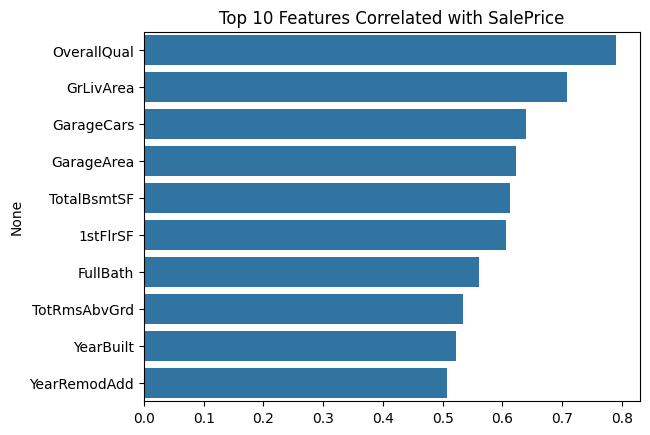

In [4]:
#EDA
def plot_t10SP(df, target, top_n=10):
    corr = df.corr(numeric_only=True)[target].sort_values(ascending=False)
    t10_corr = corr.iloc[1:top_n+1]
    sns.barplot(x=t10_corr.values, y=t10_corr.index)
    plt.title(f"Top {top_n} Features Correlated with {target}")
    plt.show()

plot_t10SP(df, 'SalePrice')

In [6]:
#Feature Engineering
df['Age'] = df['YrSold'] - df['YearBuilt']
df['TotalBathrooms'] = df['FullBath'] + 0.5 * df['HalfBath']
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

#Data cleaning
df = df.select_dtypes(include=[np.number])
df = df.fillna(df.median(numeric_only=True))

#Train-Test split:
X = df.drop(["SalePrice", "Id"], axis=1)
y = df["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#Models to try:
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

results = []

In [9]:
#Training, Evaluating, Comparing:
for name, model in models.items():
    pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse = np.sqrt(-scores.mean())
    results.append((name, rmse))

results_df = pd.DataFrame(results, columns=['Model', 'CV_RMSE']).sort_values('CV_RMSE')
print("\n Base Model Comparison:")
print(results_df)


 Base Model Comparison:
              Model       CV_RMSE
7  GradientBoosting  30696.161678
6      RandomForest  31379.281828
1             Ridge  39784.564171
4             Ridge  39784.564171
2             Lasso  40508.962319
5             Lasso  40508.962319
3            Linear  40514.233964
0            Linear  40514.233964


In [12]:
#Hyerparametr tuning
rf_params = {
    'n_estimators': randint(100, 150),
    'max_depth': randint(5, 12),
    'min_samples_split': randint(2, 6)
}

rf_random = RandomizedSearchCV(RandomForestRegressor(), rf_params, n_iter=10, cv=3,
                               scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

print("\nBest RandomForest Params:")
print(rf_random.best_params_)



Best RandomForest Params:
{'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 138}


In [13]:
#Final Model
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nFinal Evaluation on Test Set")
print(f"RMSE: {rmse_final:.2f}")
print(f"R2 Score: {r2:.4f}")


Final Evaluation on Test Set
RMSE: 29258.68
R2 Score: 0.8884


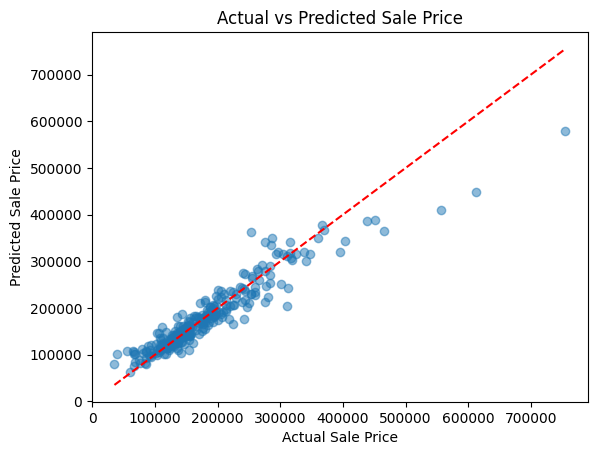

In [14]:
#Visualising for insights
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Price")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

In [15]:
#Conclusion
print("""
 Insights:
- Among base models, GradientBoosting was strong but RandomForest coupled with tuning outperformed all.
- Feature engineering (Age, TotalBathrooms) helped in improving scores.
- Future steps: try XGBoost, SHAP values for feature impact, deploy as API/Streamlit app.

 """)



 Insights:
- Among base models, GradientBoosting was strong but RandomForest with tuning outperformed all.
- Feature engineering (Age, TotalBathrooms) helped improve scores.
- Future steps: try XGBoost, SHAP values for feature impact, deploy as API/Streamlit app.

 
